# Big Five 50 Items Example


In this example, we will demonstrate how to use `xifa` to analyze a [`ipip50`](http://openpsychometrics.org/_rawdata/BIG5.zip) dataset from [openspychometrics](https://openpsychometrics.org/_rawdata/) with a confirmatory graded response model (GRM; [Semejima, 1969](https://link.springer.com/article/10.1007%2FBF03372160)). `ipip50` dataset include responses of 19719 subjects on 50 items from International Personality Item Pool (IPIP; [Goldberg, 1992](https://doi.org/10.1037/1040-3590.4.1.26)).

To open this notebook on [Google Colab](https://colab.research.google.com/), please use [link](http://colab.research.google.com/github/psyphh/xifa/blob/master/examples/ipip50.ipynb). After logging Colab, don't forget to turn on GPU by
```
Go to Menu > Runtime > Change runtime > Change hardware acceleration to GPU.
```

## Environment Setup
For first running this notebook, please install `xifa` via

In [1]:
!pip install xifa

Note that `xifa` is established on [`jax`](https://github.com/google/jax), which is officially supported only on Linux and Mac systems. Therefore, if you use a local Windows machine, `xifa` would not work.

First of all, we import all necessary packages.

In [2]:
import requests, zipfile, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jax
from xifa import GRM


By default, `jax` uses single precision for floating points arithmetics. To enable double precision arithmetics, try

In [3]:
jax.config.update("jax_enable_x64", True)

## Data Preparation

Now we download the `ipip50` dataset, unzip it, and read it as a pandas dataframe.

In [4]:
def download_dataset(dataset_url,
                     dataset_name):
    req = requests.get(dataset_url, allow_redirects=True)
    open(dataset_name + '.zip',"wb").write(req.content)
    zipfile.ZipFile(dataset_name + '.zip').extractall()
    os.remove(dataset_name+'.zip')

dataset_url = "http://openpsychometrics.org/_rawdata/BIG5.zip"
dataset_name = "ipip50"
download_dataset(dataset_url, dataset_name)
data = pd.read_csv("BIG5/data.csv", sep="\t").iloc[:,-50:]

The dataset only includes one observation with missing values (which is coded by `0` so we need to replace it by `np.nan`). However, the observation didn't response any items. Hence, we delete it.

In [5]:
data = data.replace(0, np.nan)
data = data.dropna()

If missing data are presented, `xifa` uses the so-called full-information approach for estimation. Therefore, it is unnecessary to explicitly handle `np.nan` if the assumption of missing at random (MAR) is satisfied ([Rubin, 1976](https://doi.org/10.2307/2335739)).

`xifa` requires the ordered responses to be coded from 0 to C-1, where C is the number of ordered categories. Because the original responses are coded from 1 to C, we need to subtract all values by 1 and reverse the coding for "negative items".

In [6]:
data = data - 1.0
negative_items = ["E2", "E4", "E6", "E8", "E10",
                  "N2", "N4",
                  "A1", "A3", "A5", "A7",
                  "C2", "C4", "C6", "C8",
                  "O2", "O4", "O6"]
data[negative_items] = 4 - data[negative_items]


We use the heat map of correlation matrix to check whether our reversing is correct.

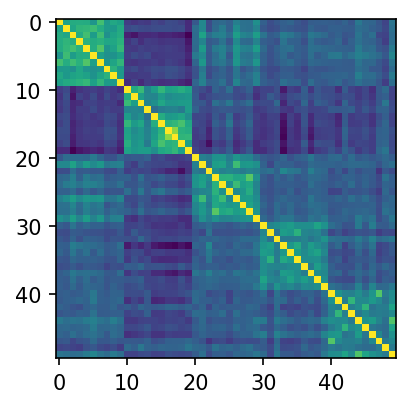

In [7]:
plt.figure(figsize=(3, 3), dpi=150)
plt.imshow(data.corr(),
           cmap='viridis')
plt.show()

## IFA Implementation
Finally, we conduct IFA by using the `GRM` object imported from `xifa`. To initialize a `GRM` instance, a dataset (`data`) and a number of factors (`n_factors`) must be specified. The data must be a two dimensional floating point array (`n_cases * n_items`) that can be transformed to `jax.numpy.array`. For a confirmatory analysis, a pattern dictionary is also required. This pattern dictionary specifies the relationship among items and factors by their indices (starting form `0`). If pattern is specified, the model is treated as confirmatory and factor correlations are all estimated. Otherwise, the model is treated as exploratory and an orthogonal structure is assumed.

In [8]:
n_factors = 5
n_items = 50
q = int(n_items / n_factors)
pattern = {"loading":{m: set(range(m * q, (m + 1) * q)) for m in range(n_factors)}}
grm = GRM(data=data,
          n_factors=5,
          pattern=pattern)

A GRM Object is Initialized Successfully.
 + Number of Cases: 19718
 + Number of Items: 50
 + Number of Factors: 5
 + Number of Categories: 5


The marginal maximum likelihood (MML) estimation can be implemented by the `fit()` method. `xifa` implements MML by a vectorized Metropolis-Hastings Robbins-Monro (MH-RM) algorithm. The algorithm includes two stages StEM and SAEM. The first stage updates the parameter estimate by a stochastic expectation-maximization (StEM) algorithm with `discard_iter` iterations. The second stage conducts stochastic approximation expectation-maximization (SAEM) with gain defined by `1 / (iter - discard_iter) ** sa_power`, where `iter` is the iteration counter.

In [9]:
grm.fit(lr=1.,
        max_iter=1000,
        discard_iter=200,
        tol=10 ** (-4),
        window_size=3,
        chains=1,
        warm_up=5,
        jump_scale="default",
        adaptive_jump=True,
        target_rate=.23,
        jump_change=.01,
        sa_power=1.,
        corr_update="gd",
        verbose=True,
        key=None,
        batch_size=None,
        batch_shuffle=None,
        params=None,
        masks=None)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

Converged after 284 Iterations (224.07 sec).


In this example, CPU takes about 5-10 minutes to finish the optimization job. If any GPU is available, the job can be speed up. On Colab with GPU, the job takes about 30 seconds.


The MML parameter estimate is stored in the `params` attribute in `grm`. `params` is a dictionary with three elements: `intercept` for intercepts, `loading` for factor loadings, and `corr` for factor correlations. For example,

In [10]:
print(np.round(grm.params["corr"], 3))

[[ 1.    -0.293  0.417  0.154  0.229]
 [-0.293  1.    -0.101 -0.333 -0.135]
 [ 0.417 -0.101  1.     0.205  0.181]
 [ 0.154 -0.333  0.205  1.     0.122]
 [ 0.229 -0.135  0.181  0.122  1.   ]]


It is also possible to use an averaged parameter estimate by `aparams` attribute, which is the mean of parameter estimates obtained in the SAEM stage.

The optimization history is stored in the `trace` attribute. To see how the complete data loss changes over optimization, we may use

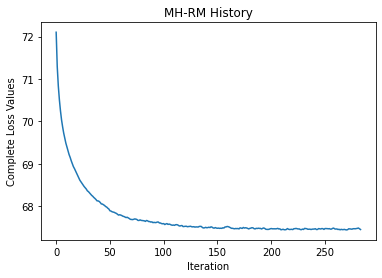

In [11]:
plt.plot(grm.trace["closs"])
plt.ylabel('Complete Loss Values')
plt.xlabel('Iteration')
plt.title('MH-RM History')
plt.show()